In [1]:
# Amplitude Envelope
# Root Mean Square Energy
# Magnitude Spectrum 
# STFT (with Hann Window)
# Spectrogram
# Band Energy Ratio
# Mel Spectrogram
# MFCC

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from librosa import load
import librosa.display

# Parameters

In [3]:
FRAME_LENGTH = 512
HOP_LENGTH = 256

# Audio files

### 1

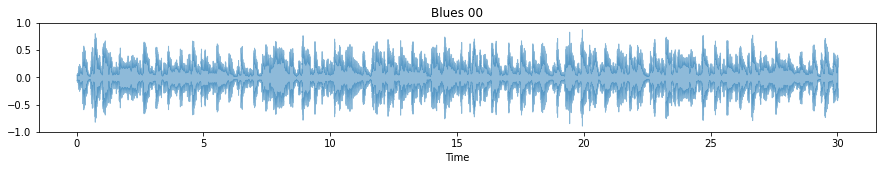

In [4]:
blues, sr = load("blues_00.wav") # sr=22050
plt.figure(figsize=(15, 2))
librosa.display.waveshow(blues, alpha=0.5)
plt.title("Blues 00")
plt.ylim((-1, 1))
plt.show()

In [5]:
ipd.Audio("blues_00.wav")

### 2

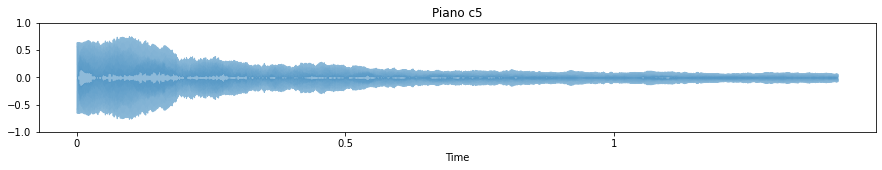

In [6]:
piano_c5, sr = load("piano_c5.wav") # sr=22050
plt.figure(figsize=(15, 2))
librosa.display.waveshow(piano_c5, alpha=0.5)
plt.title("Piano c5")
plt.ylim((-1, 1))
plt.show()

In [7]:
ipd.Audio("piano_c5.wav")

---

# Amplitude Envelope

In [8]:
def amplitude_envelope(signal, frame_size, hop_length):
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])

---

In [9]:
ae_blues = amplitude_envelope(blues, FRAME_LENGTH, HOP_LENGTH)

In [10]:
frames = range(len(ae_blues))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

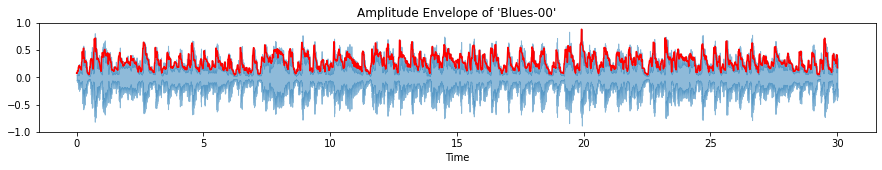

In [11]:
plt.figure(figsize=(15, 2))
librosa.display.waveshow(blues, alpha=0.5)
plt.plot(t, ae_blues, color="r")
plt.title("Amplitude Envelope of 'Blues-00'")
plt.ylim((-1, 1))
plt.show()

---

In [12]:
ae_c5 = amplitude_envelope(piano_c5, FRAME_LENGTH, HOP_LENGTH)

In [13]:
frames = range(len(ae_c5))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

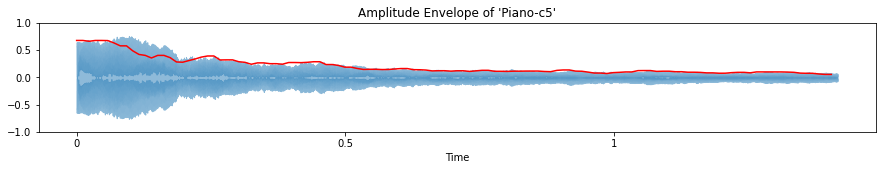

In [14]:
plt.figure(figsize=(15, 2))
librosa.display.waveshow(piano_c5, alpha=0.5)
plt.plot(t, ae_c5, color="r")
plt.title("Amplitude Envelope of 'Piano-c5'")
plt.ylim((-1, 1))
plt.show()

---

# Root Mean Square Energy

In [15]:
def rms_energy(signal, frame_length, hop_length):
    rms = []
    for i in range(0, len(signal), hop_length):
        current_frame_rms = np.sqrt(np.sum(signal[i:i+frame_length]**2) / frame_length)
        rms.append(current_frame_rms)
    return np.array(rms)

---

In [16]:
rms_blues = rms_energy(blues, FRAME_LENGTH, HOP_LENGTH)

In [17]:
frames = range(len(rms_blues))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

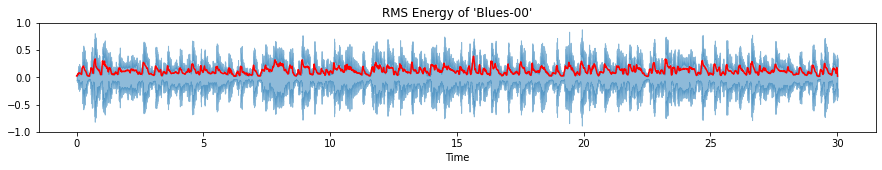

In [18]:
plt.figure(figsize=(15, 2))
librosa.display.waveshow(blues, alpha=0.5)
plt.plot(t, rms_blues, color="r")
plt.title("RMS Energy of 'Blues-00'")
plt.ylim((-1, 1))
plt.show()

---

In [19]:
rms_c5 = rms_energy(piano_c5, FRAME_LENGTH, HOP_LENGTH)

In [20]:
frames = range(len(rms_c5))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

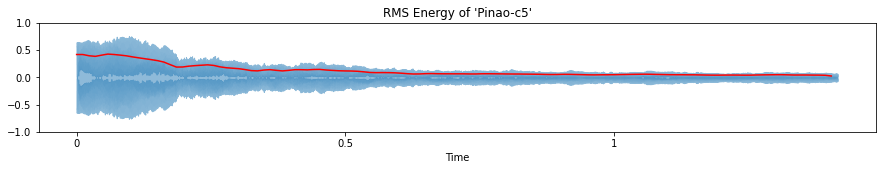

In [21]:
plt.figure(figsize=(15, 2))
librosa.display.waveshow(piano_c5, alpha=0.5)
plt.plot(t, rms_c5, color="r")
plt.title("RMS Energy of 'Pinao-c5'")
plt.ylim((-1, 1))
plt.show()

---

# Magnitude Spectrum 

In [22]:
def plot_magnitude_spectrum(signal, sr, title, f_ratio=1):
    
    ft = np.fft.fft(signal)
    mag_ft = np.abs(ft)
    
    actual_mag_ft = np.concatenate((mag_ft[int(np.round(len(mag_ft)/2)):], mag_ft[:int(np.round(len(mag_ft)/2))]))
    
    # Plot spectrum
    plt.figure(figsize=(18, 5))
    
    f = np.linspace(-sr/2, sr/2, len(signal))
    length_f = len(f)
    
    plt.plot(f[int((1-f_ratio)/2*length_f) : length_f-int((1-f_ratio)/2*length_f)], 
             actual_mag_ft[int((1-f_ratio)/2*length_f) : length_f-int((1-f_ratio)/2*length_f)])
    plt.xlabel("f (Hz)")
    plt.ylabel("|X(f)|")
    plt.title("Magnitude Spectrum of " + title)  
    plt.show()

---

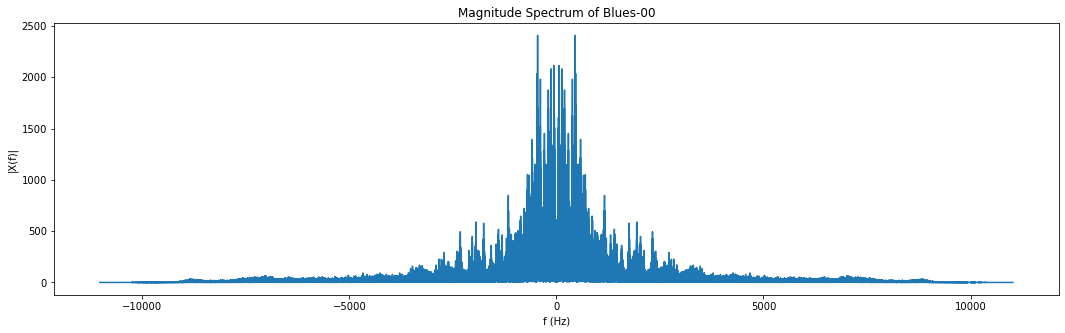

In [23]:
plot_magnitude_spectrum(blues, sr, 'Blues-00')

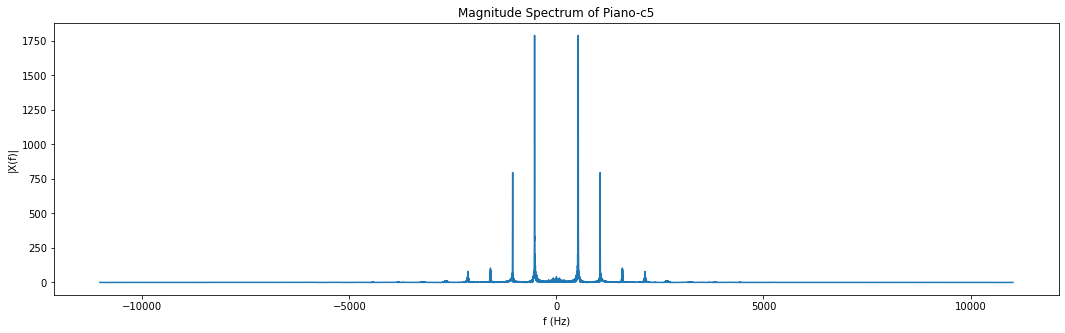

In [24]:
plot_magnitude_spectrum(piano_c5, sr, 'Piano-c5')

---

# STFT (with Hann Window)

In [25]:
hann = np.sin((np.pi/FRAME_LENGTH)*np.arange(FRAME_LENGTH))**2

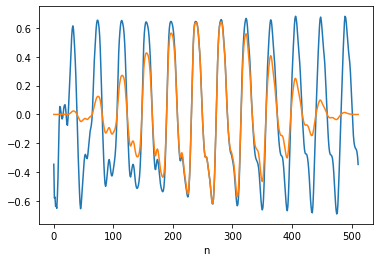

In [26]:
# original signal multiply Hann window
plt.plot(np.arange(FRAME_LENGTH), piano_c5[:FRAME_LENGTH])
plt.plot(np.arange(FRAME_LENGTH), piano_c5[:FRAME_LENGTH]*hann)
plt.xlabel("n")
plt.show()

In [27]:
def hann_STFT(signal, frame_length, hop_length):
    
    hann = np.sin((np.pi/frame_length)*np.arange(frame_length))**2
    
    for i in range(0, len(signal), hop_length):
        
        current_frame = signal[i:i+frame_length]
        if len(current_frame) < frame_length:
            current_frame = np.concatenate((current_frame, np.zeros(frame_length-len(current_frame))))
            
        current_frame = current_frame*hann
            
        current_frame_ft = np.fft.fft(current_frame)
        current_frame_ft = current_frame_ft[:int(frame_length/2)]
        
        if i > 0:
            stack_frame_ft = np.concatenate((stack_frame_ft, current_frame_ft.reshape(1, -1)))
        else:
            stack_frame_ft = current_frame_ft.reshape(1, -1)
    
    return stack_frame_ft.T

---

In [28]:
STFT_blues = hann_STFT(blues, FRAME_LENGTH, HOP_LENGTH)

In [29]:
STFT_c5 = hann_STFT(piano_c5, FRAME_LENGTH, HOP_LENGTH)

---

# Spectrogram

In [30]:
def plot_spectrogram(spectrogram, sr, hop_length, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),
                             sr=sr,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis="log")
    plt.colorbar(format="%+2.f dB")
    plt.title("Log-Power spectrogram of " + title)
    plt.show()

---

In [31]:
spectrogram_blues = np.abs(STFT_blues)**2

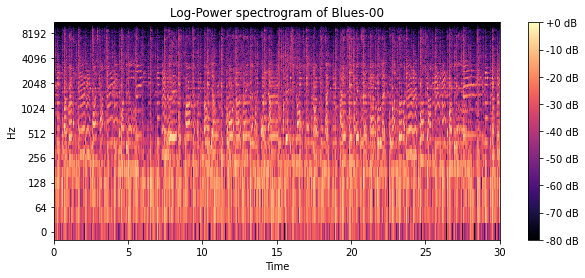

In [32]:
plot_spectrogram(spectrogram_blues, sr, HOP_LENGTH, 'Blues-00')

---

In [33]:
spectrogram_c5 = np.abs(STFT_c5)**2

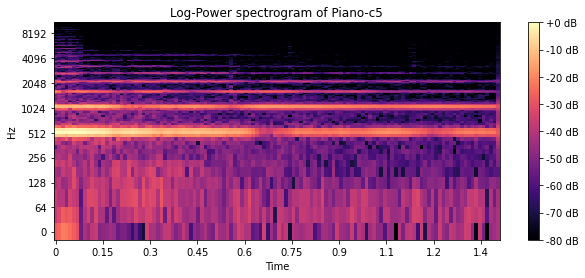

In [34]:
plot_spectrogram(spectrogram_c5, sr, HOP_LENGTH, 'Piano-c5')

---

# Band Energy Ratio

In [35]:
def band_energy_ratio(spectrogram, split_frequency, sr):
    
    split_frequency_index = int(np.round(split_frequency*spectrogram.shape[0]/(sr/2)))
    spectrogram = spectrogram.T
    
    total_ber = []
    for current_frame_stg in spectrogram:
        
        low_frequencies_sum = np.sum(current_frame_stg[:split_frequency_index]**2)
        high_frequencies_sum = np.sum(current_frame_stg[split_frequency_index:]**2)
        current_frame_ber = low_frequencies_sum / high_frequencies_sum
        total_ber.append(current_frame_ber)
        
    return np.array(total_ber)

---

In [36]:
ber_blues = band_energy_ratio(spectrogram_blues, 2000, sr)

In [37]:
frames = range(len(ber_blues))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

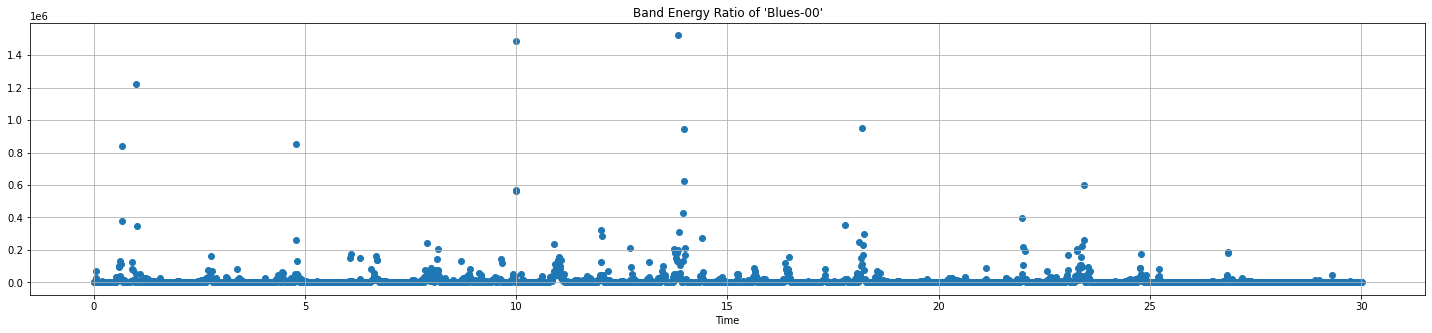

In [38]:
plt.figure(figsize=(25, 5))
plt.scatter(t, ber_blues)
plt.xlabel("Time")
plt.title("Band Energy Ratio of 'Blues-00'")
plt.grid(True)
plt.show()

---

In [39]:
ber_c5 = band_energy_ratio(spectrogram_c5, 2000, sr)

In [40]:
frames = range(len(ber_c5))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

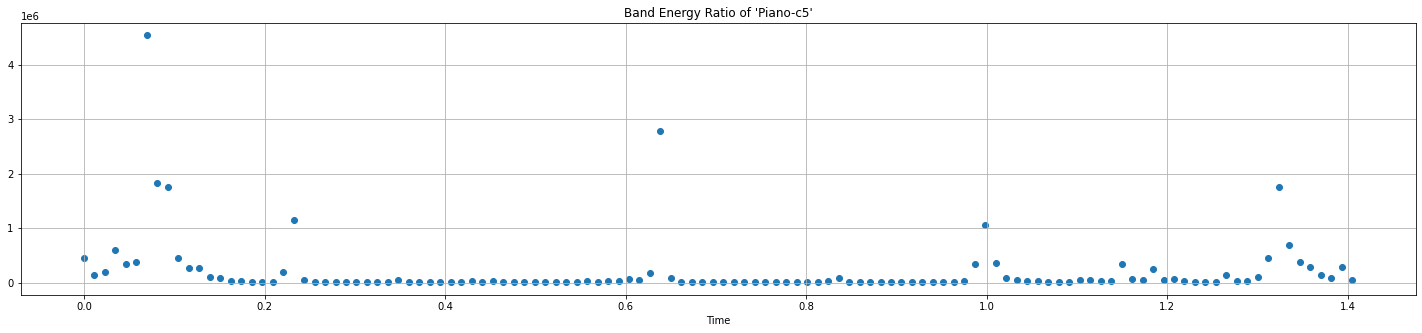

In [41]:
plt.figure(figsize=(25, 5))
plt.scatter(t, ber_c5)
plt.xlabel("Time")
plt.title("Band Energy Ratio of 'Piano-c5'")
plt.grid(True)
plt.show()

---

# Mel Spectrogram

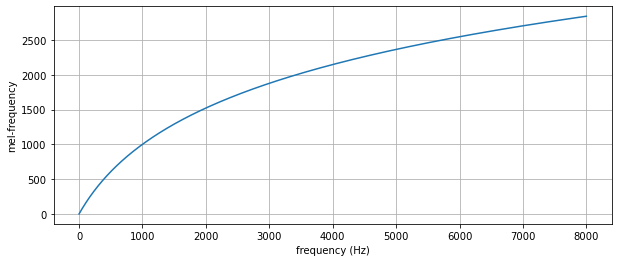

In [42]:
f = np.arange(8000)
m = 1127*np.log(1+f/700)
plt.figure(figsize=(10, 4))
plt.plot(f, m)
plt.xlabel("frequency (Hz)")
plt.ylabel("mel-frequency")
plt.grid(True)
plt.show()

In [43]:
def mel_masks(n_mels, sr, frame_length):
    
    low_mel = 0
    high_mel = 1127 * np.log(1 + (sr/2)/700)
    mel_points = np.linspace(low_mel, high_mel, n_mels+2)
    hz_points = 700 * (np.exp(mel_points/1127) - 1)
    freq_index = np.floor(frame_length * hz_points / sr)
    
    filter_bank = np.zeros((n_mels, int(frame_length/2) + 1))
    for m in range(1, n_mels+1):
        fm_minus = int(freq_index[m-1])
        fm = int(freq_index[m])
        fm_plus = int(freq_index[m+1])
        
        for k in range(fm_minus, fm):
            filter_bank[m-1, k] = (k - freq_index[m-1]) / (freq_index[m] - freq_index[m-1])
        for k in range(fm, fm_plus):
            filter_bank[m-1, k] = (freq_index[m+1] - k) / (freq_index[m+1] - freq_index[m])
    
    return filter_bank

In [44]:
def mel_spectrogram(signal, n_mels, sr, frame_length, hop_length):
    
    spectrogram = np.abs(hann_STFT(signal, frame_length, hop_length))**2
    filter_bank = mel_masks(n_mels, sr, frame_length)  
    reshape_spectrogram = np.concatenate((spectrogram, spectrogram[-1].reshape(1, -1)))
    
    for frame_index in range(spectrogram.shape[1]):
        
        Ym = []
        for i in range(n_mels):
            Ym.append(sum(reshape_spectrogram.T[frame_index] * filter_bank[i]))
        
        current_frame_mel = np.array(Ym)
        
        if frame_index > 0:
            stack_frame_mel = np.concatenate((stack_frame_mel, current_frame_mel.reshape(1, -1)))
        else:
            stack_frame_mel = current_frame_mel.reshape(1, -1)
    
    return stack_frame_mel.T

In [45]:
def plot_mel_spectrogram(mel_spectrogram, sr, hop_length, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                             sr=sr,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis="mel")
    plt.colorbar(format="%+2.f dB")
    plt.title("Log-Power Mel spectrogram of " + title)
    plt.show() 

---

In [46]:
mel_spectrogram_blues = mel_spectrogram(blues, 40, sr, FRAME_LENGTH, HOP_LENGTH)

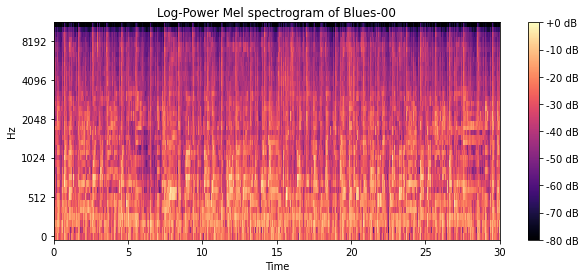

In [47]:
plot_mel_spectrogram(mel_spectrogram_blues, sr, HOP_LENGTH, 'Blues-00')

---

In [48]:
mel_spectrogram_c5 = mel_spectrogram(piano_c5, 40, sr, FRAME_LENGTH, HOP_LENGTH)

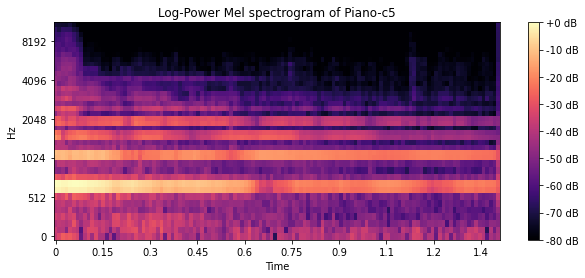

In [49]:
plot_mel_spectrogram(mel_spectrogram_c5, sr, HOP_LENGTH, 'Piano-c5')

---

# MFCC

In [50]:
def mfcc(signal, n_mfcc, n_mels, sr, frame_length, hop_length):
    
    log_mel_stg = np.log(mel_spectrogram(signal, n_mels, sr, frame_length, hop_length))
    M = log_mel_stg.shape[0]
    
    for frame_index in range(log_mel_stg.shape[1]):
        coef_n = []
        for n in range(n_mfcc):    
            dct_sum = 0
            for m in range(M):
                dct_sum += log_mel_stg.T[frame_index][m]*np.cos((np.pi*n*(m-0.5))/M)
            coef_n.append(dct_sum/M)
        
        current_frame_mfcc = np.array(coef_n)
        
        if frame_index > 0:
            stack_frame_mfcc = np.concatenate((stack_frame_mfcc, current_frame_mfcc.reshape(1, -1)))
        else:
            stack_frame_mfcc = current_frame_mfcc.reshape(1, -1)
        
    return stack_frame_mfcc.T

In [51]:
def plot_mfcc(mfcc, sr, hop_length, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc,
                             sr=sr,
                             hop_length=hop_length,
                             x_axis="time")
    plt.colorbar(format="%+2.f")
    plt.title("MFCC of " + title)
    plt.show() 

---

In [52]:
mfcc_blues = mfcc(blues, 13, 40, sr, FRAME_LENGTH, HOP_LENGTH)

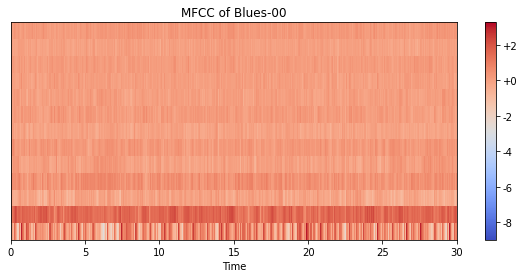

In [53]:
plot_mfcc(mfcc_blues, sr, HOP_LENGTH, 'Blues-00')

---

In [54]:
mfcc_c5 = mfcc(piano_c5, 13, 40, sr, FRAME_LENGTH, HOP_LENGTH)

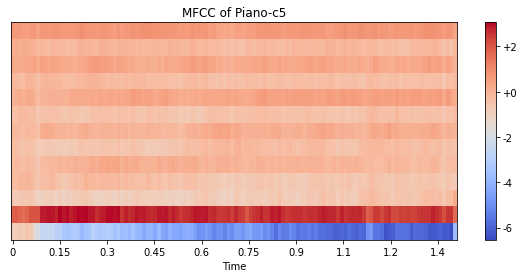

In [55]:
plot_mfcc(mfcc_c5, sr, HOP_LENGTH, 'Piano-c5')

---

# Sound + Noise

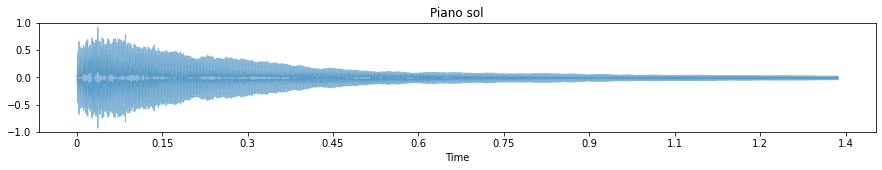

In [56]:
piano_sol, sr = load("piano_sol.wav") # sr=22050
plt.figure(figsize=(15, 2))
librosa.display.waveshow(piano_sol, alpha=0.5)
plt.title("Piano sol")
plt.ylim((-1, 1))
plt.show()

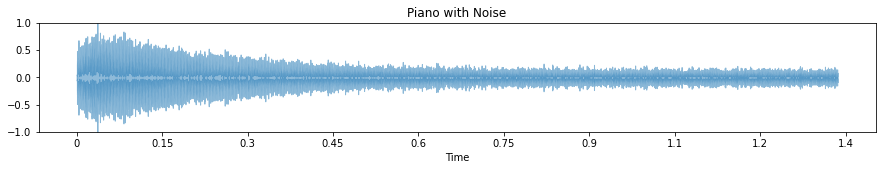

In [57]:
piano_n, sr = load("piano_with_noise.wav") # sr=22050
plt.figure(figsize=(15, 2))
librosa.display.waveshow(piano_n, alpha=0.5)
plt.title("Piano with Noise")
plt.ylim((-1, 1))
plt.show()

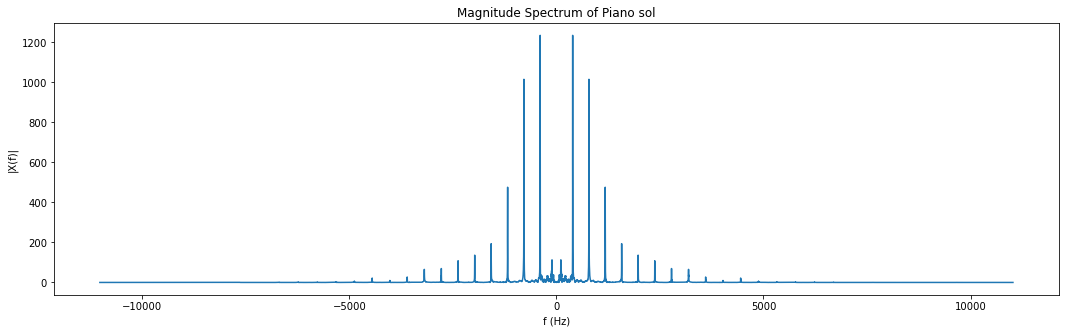

In [58]:
plot_magnitude_spectrum(piano_sol, sr, 'Piano sol')

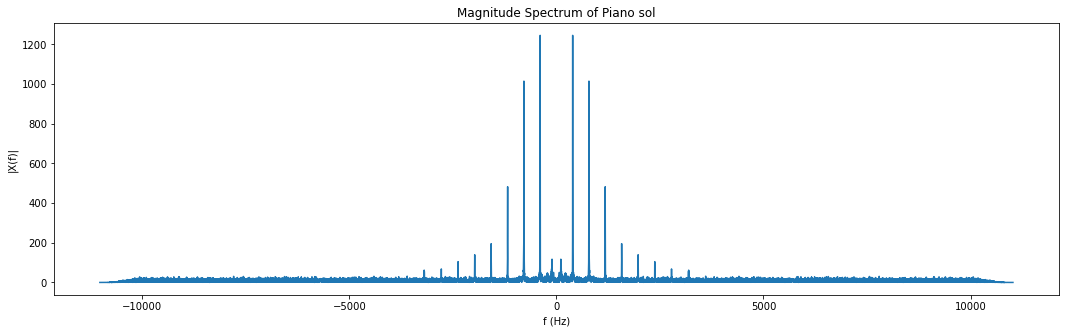

In [59]:
plot_magnitude_spectrum(piano_n, sr, 'Piano sol')

In [60]:
STFT_sol = hann_STFT(piano_sol, FRAME_LENGTH, HOP_LENGTH)
STFT_n = hann_STFT(piano_n, FRAME_LENGTH, HOP_LENGTH)

In [61]:
spectrogram_sol = np.abs(STFT_sol)**2
spectrogram_n = np.abs(STFT_n)**2

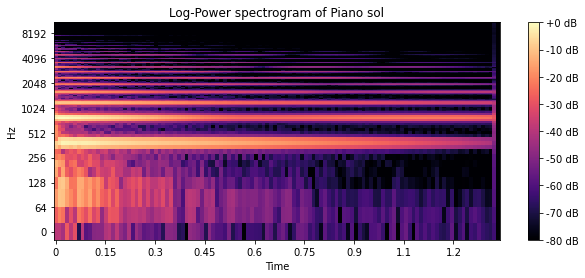

In [62]:
plot_spectrogram(spectrogram_sol, sr, HOP_LENGTH, 'Piano sol')

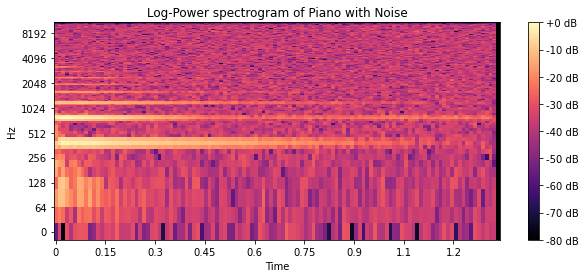

In [63]:
plot_spectrogram(spectrogram_n, sr, HOP_LENGTH, 'Piano with Noise')